In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

<h1>Importación de datos</h1>

In [2]:
df = pd.read_csv("emnist_letters_tp.csv", header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>Analisis exploratorio de datos</h1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62400 entries, 0 to 62399
Columns: 785 entries, 0 to 784
dtypes: int64(784), object(1)
memory usage: 373.7+ MB


In [5]:
df[0].nunique()

26

In [6]:
df[0].value_counts()

0
F    2400
Q    2400
I    2400
B    2400
X    2400
R    2400
A    2400
G    2400
V    2400
U    2400
Y    2400
M    2400
N    2400
S    2400
Z    2400
P    2400
T    2400
J    2400
E    2400
H    2400
C    2400
O    2400
D    2400
K    2400
W    2400
L    2400
Name: count, dtype: int64

**Cantidad de datos** Hay 62400 filas, cada una con 785 columnas.<br>
**Atributos** Hay 785 atributos, 784 numericos y el primero es un caracter, el indicador de la letra (variable de interes).<br>
**Clase de interes** Hay  26 valores distintos para la clase de interes, todos presentes en igual proporcion.

<h3>Veamos algunos ejemplos de letras</h3>

In [7]:
def flip_rotate(image):
    """
    Función que recibe un array de numpy representando una
    imagen de 28x28. Espeja el array y lo rota en 90°.
    """
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [8]:
Es = df[df[0] == "E"]
Ls = df[df[0] == "L"]
Ms = df[df[0] == "M"]

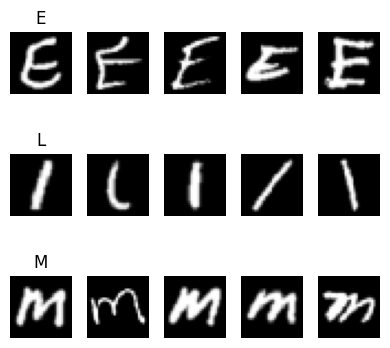

In [9]:
# Definir los dataframes en un diccionario para facilitar el bucle
letras = {'E': Es, 'L': Ls, 'M': Ms}

fig, axs = plt.subplots(3, 5, figsize=(4, 4))  # 3 filas para las letras, 5 columnas para ejemplos de cada letra

for i, (letras, data) in enumerate(letras.items()):
    # Obtener las primeras 5 imágenes del dataframe actual
    for j in range(5):
        row = data.iloc[j].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(letras)

plt.tight_layout()
plt.show()

**Veamos las Ces**

<Figure size 640x480 with 0 Axes>

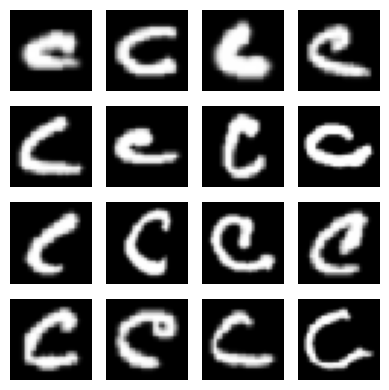

In [10]:
Cs = df[df[0] == "C"]

plt.clf()
fig, axs = plt.subplots(4,4, figsize=(4,4))

for i in range(4):
    for j in range(4):
        random = np.random.randint(0,2399) #elejimos un C al azar
        row = Cs.iloc[random].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
Cs.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
7,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Ejercicio 1</h3>
<h3>(a)</h3> Los atributos de los pixeles son la unica informacion que tenemos para predecir la letra correspondiente, por lo que son estos atributos (o columnas) fundamentales para lograr nuestra tarea. Sin embargo se puede notar que los valores correspondientes a las esquinas y bordes de la imagen son en su mayoria igual a cero. Quizas podriamos reducir la cantidad de piexeles por imagen y prescindir de esos datos.<br>
<h3>(b, c)</h3> Las letras no son parecidas, incluso varian mucho las imagenes de una misma letra. Sin embargo cabe notar que si se comparan de a tres (como con la E, la M y la L), se podría decir que hay un par con mas similitudes entre sí. Para el ejemplo arriba visto podemos observar mayores similitudes entre la M y la E, pues ambas presentan un patron de tres rayas, la E hacia la derecha y la M los presenta hacia abajo.<br>
<h3>(d)</h3> En este caso la exploración de datos se debe tomar por otro enfoque, no  se tratará de graficos de caja o de histogramas, ya que no servirian ningún proposito, lo importante en una base de datos de imagenes es poder verlas, ver patrones en ellas, identificar la cantidad de colores tal vez, el tamaño de cada imagen; y por sobre todas las cosas, ver que valores puede tomar cada imagen, para responder la cantidad de posibles valores distintos, y que porcentaje representa cada uno de estos en el conjunto de datos.

<hr>

<h3>Ejercicio 2</h3>

<h3>(a) y (b)</h3>

In [12]:
LAs = df[df[0].isin(["A","L"])] # item a

# (item b) por analisis anteriores sabemos que estos datos estan
# balanceados, ambas letras estan en 2400 filas

<h3>(c)</h3>

In [13]:
# separamos las labels
X = LAs.drop(0, axis=1)
y = LAs[0]

In [14]:
# separamos los datos en conjuntos train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

<h3>(d)</h3>

In [15]:
resultados3=[]

for i in range(15):   # pruebo con 15 combinaciones distintas
    combinacion = np.random.randint(1, 785, size=3)    # tomo de forma random 3 de las columnas 
    X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas random
    X_test_subset = X_test[combinacion]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_subset,y_train) 
    y_pred = knn.predict(X_test_subset)
    resultados3.append((combinacion,metrics.accuracy_score(y_test, y_pred)))

resultados3 = sorted(resultados3, key=lambda x: x[1], reverse=True)

print(resultados3)

[(array([186, 532, 604]), 0.9159722222222222), (array([241, 775, 483]), 0.8222222222222222), (array([452, 629, 663]), 0.8055555555555556), (array([268,  97, 783]), 0.8013888888888889), (array([306, 413, 680]), 0.7854166666666667), (array([555, 302, 308]), 0.7722222222222223), (array([614, 131, 637]), 0.7597222222222222), (array([147, 302, 766]), 0.7277777777777777), (array([416, 666, 606]), 0.7215277777777778), (array([715,  20, 204]), 0.6229166666666667), (array([511, 408, 762]), 0.6145833333333334), (array([112, 404, 562]), 0.54375), (array([722,  98, 677]), 0.4930555555555556), (array([643,  66, 648]), 0.4888888888888889), (array([ 78, 740, 755]), 0.48819444444444443)]


Notamos que las columnas del medio nos dan un buen resultado, como es de esperarse.<br>
Probemos eligiendolas manualmente.

In [16]:
combinacion = [391,392,393]    # tomo las 3 columnas del medio
X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas seleccionadas
X_test_subset = X_test[combinacion]
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_subset,y_train) 
y_pred = knn.predict(X_test_subset)

In [17]:
print(metrics.accuracy_score(y_test, y_pred))

0.5305555555555556


Interesante, me dio muy mal la métrica, lo puedo interpretar como que las 3 columnas son muy redundantes en informacion, por lo reduzco la cantidad de datos significativos con los que el modelo puede predecir.

Veamos en un gráfico la idea.

<Figure size 640x480 with 0 Axes>

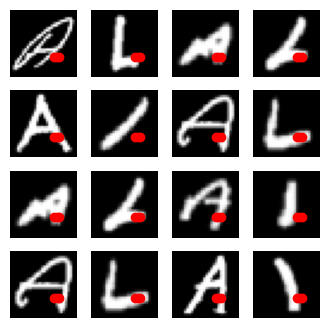

In [18]:
plt.clf()

np.random.seed(42)
random = np.random.randint(0,2399, size=16)
fig, axs = plt.subplots(4,4,figsize=(4,4))

for j in range(4):
    for i, letra in enumerate(["A","L","A","L"]):
        row = df[df[0] == letra].iloc[random[i + j + 2]].drop(0)
        image_array = np.array(row).astype(np.float32)
        image = flip_rotate(image_array)
        axs[j,i].imshow(image, cmap='gray')
        axs[j,i].scatter([18,19,20], [19,19,19],color='red') # señalamos 3 atributos cercanos
        axs[j,i].axis('off')

Se puede ver que 3 puntos cercanos no nos dan tanta informacion, ambas letras presentan ejemplos de puntos similares, donde hay casos que son todos blancos, o todos negros, o donde hay ambos colores; pero la proporcion de estos casos no varía mucho entre estos caracteres, por lo que dificulta la obtencion de un buen resultado usando el algoritmo de KNN.

**Veamos ahora que pasa con otra cantidad de atributos**

In [19]:
# probamos con 9 atributos

resultados9=[]

for i in range(15):   # pruebo con 15 combinaciones distintas
    combinacion = np.random.randint(1, 785, size=9)    # tomo de forma random 9 de las columnas 
    X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas random
    X_test_subset = X_test[combinacion]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_subset,y_train) 
    y_pred = knn.predict(X_test_subset)
    resultados9.append((combinacion,metrics.accuracy_score(y_test, y_pred)))

resultados9 = sorted(resultados9, key=lambda x: x[1], reverse=True)

print(resultados9)

[(array([503, 407, 574, 728,  99, 684, 726, 547, 739]), 0.9645833333333333), (array([393, 207,  15, 554, 461, 691, 575, 743, 241]), 0.9493055555555555), (array([157,  15,  65, 521, 344, 129, 648, 472,  63]), 0.9361111111111111), (array([ 21, 167, 274, 388, 601, 316,  14, 242, 777]), 0.9159722222222222), (array([749, 338,  53, 217, 764, 188, 380, 493,  41]), 0.8972222222222223), (array([414, 386, 192, 277, 161, 460, 314,  22, 253]), 0.8902777777777777), (array([190, 687, 563, 567, 244, 505, 131, 485, 647]), 0.8666666666666667), (array([271, 456, 462, 727, 252, 702, 296, 725, 720]), 0.8451388888888889), (array([346, 565, 340,  92, 367, 455, 428, 509, 776]), 0.8083333333333333), (array([772, 477, 703, 402, 730, 556, 162, 202, 270]), 0.7965277777777777), (array([490, 231,  41,  28, 135, 201, 780,  33,  48]), 0.7944444444444444), (array([ 35, 206,  81, 562, 388,   2, 390, 566, 106]), 0.7930555555555555), (array([139, 499, 593, 392, 675, 419, 289, 379, 773]), 0.7618055555555555), (array([613

Hubo una mejora, de un 1%. Veamos que pasa si aumentamos la cantidad de atributos. Probemos con 21.

In [20]:
resultados21=[]

for i in range(15):   # pruebo con 15 combinaciones distintas
    combinacion = np.random.randint(1, 785, size=21)    # tomo de forma random 21 de las columnas 
    X_train_subset = X_train[combinacion]     # asigno un subset donde tomo del X_train las columnas random
    X_test_subset = X_test[combinacion]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_subset,y_train) 
    y_pred = knn.predict(X_test_subset)
    resultados21.append((combinacion,metrics.accuracy_score(y_test, y_pred)))

resultados21 = sorted(resultados21, key=lambda x: x[1], reverse=True)

print(resultados21[:5]) # imprimo solo los primeros 5, sino es muy largo

[(array([564,  96, 734, 485, 407, 231, 749, 655, 171, 541,  36, 525, 160,
       699, 243,  86, 578, 682, 557, 574, 646]), 0.9645833333333333), (array([220, 158, 477,  46, 373, 518,  99, 745,  37, 280, 349, 497, 302,
       181, 607,  99, 700, 116, 191, 253, 161]), 0.9590277777777778), (array([665, 698, 575, 190, 125, 150, 314, 570, 342, 305, 692, 682, 783,
        54, 444, 613, 264,  53, 572, 620,   5]), 0.9576388888888889), (array([230, 365, 563, 438, 776, 283,  27, 226, 277, 609, 284, 481, 453,
       659, 516, 547, 192,  49, 512,  17, 172]), 0.9548611111111112), (array([256, 323, 128,  18, 735, 566, 570, 323, 686, 626, 288, 663, 639,
       155, 490, 386, 104, 393, 246, 176,  39]), 0.9527777777777777)]


In [37]:
# veamos un poco de informacion sobre los resultados obtenidos
print(f"""
    Con 3 atributos\n
         Exactitud máxima: {resultados3[0][1]:.3}.\n
         Exactitud media: {np.mean([exactitud[1] for exactitud in resultados3]):.3}.\n\n
    Con 9 atributos\n
         Exactitud máxima: {resultados9[0][1]:.3}.\n
         Exactitud media: {np.mean([exactitud[1] for exactitud in resultados9]):.3}.\n\n
    Con 21 atributos\n
         Exactitud máxima: {resultados21[0][1]:.3}.\n
         Exactitud media: {np.mean([exactitud[1] for exactitud in resultados21]):.3}.
""")


    Con 3 atributos

         Exactitud máxima: 0.916.

         Exactitud media: 0.691.


    Con 9 atributos

         Exactitud máxima: 0.965.

         Exactitud media: 0.832.


    Con 21 atributos

         Exactitud máxima: 0.965.

         Exactitud media: 0.93.



Observamos que la mejor marca no aumenta significativamente, sin embargo, en promedio los resultados para 15 experimentos son mucho mejores.

<h3>(e)</h3>

La idea ahora es comparar los modelos de KNN, perov variando tambien los numeros de vecinos

Nos va a facilitar la tarea modularizar el codigo en funciones que tomen lo que ya hemos hecho hasta ahora. Asi que primero hacemos eso para que luego sea mas sencillo entrenar modelos con diferentes parametros.